<a href="https://colab.research.google.com/github/Benard-W/-Performance-Analysis/blob/main/CX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/customer_ticket_data.csv")

In [ ]:
df.head()

,Ticket_ID,Category,Priority,Channel,Agent,Customer_Type,Time_Open_Hour,Resolution_Time_Hours
0,1,Account,Low,Phone,Agent_D,New,17,60.9
1,2,General,Medium,Chat,Agent_B,Returning,4,53.5
2,3,Billing,High,Chat,Agent_B,New,14,40.5
3,4,Account,Medium,Phone,Agent_A,New,16,52.7
4,5,Account,Low,Phone,Agent_A,New,2,65.6


In [ ]:
X = df.drop(columns=["Ticket_ID", "Resolution_Time_Hours"])
y = df["Resolution_Time_Hours"]

In [ ]:
categorical_cols = ["Category", "Priority", "Channel", "Agent", "Customer_Type"]
numerical_cols = ["Time_Open_Hour"]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 41.75912089615928
R² Score: 0.536949225811161


In [ ]:
# Get feature names after OneHotEncoding
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_cols)

# Combine with numeric columns
all_feature_names = list(encoded_cols) + numerical_cols



In [ ]:
# Access the trained model
rf_model = model.named_steps['regressor']

# Get importances
importances = rf_model.feature_importances_


In [ ]:
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

<ipython-input-14-be9dd17719ed>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette="viridis")


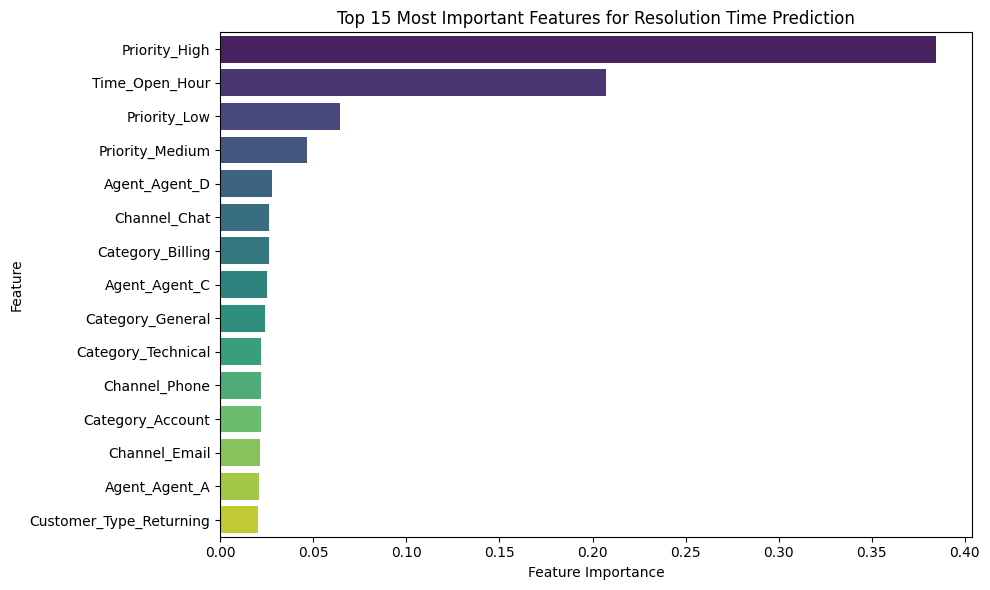

In [ ]:
# Plot the top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette="viridis")
plt.title("Top 15 Most Important Features for Resolution Time Prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


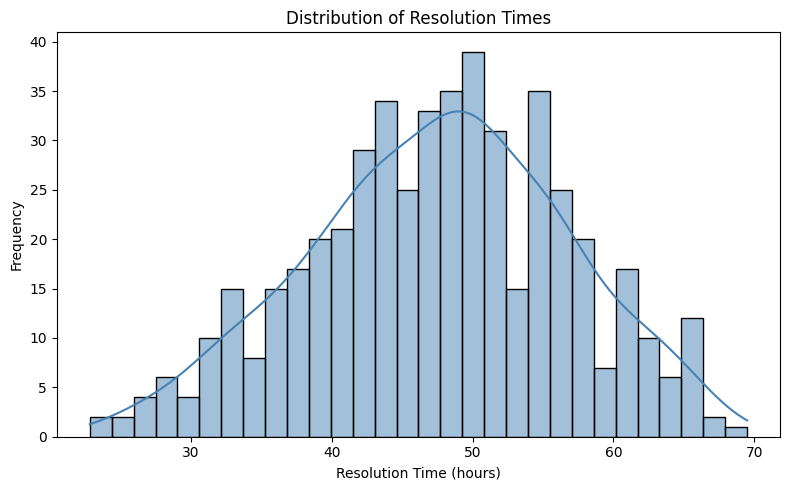

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Resolution_Time_Hours"], bins=30, kde=True, color="steelblue")
plt.title("Distribution of Resolution Times")
plt.xlabel("Resolution Time (hours)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


<ipython-input-16-bd7a01dc1747>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x="Time_Open_Hour", y="Resolution_Time_Hours", estimator='mean', ci='sd')


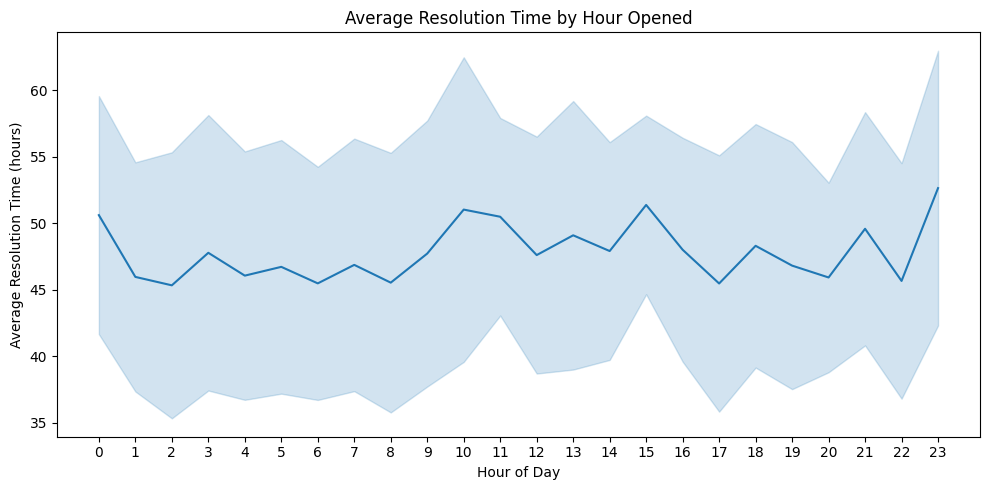

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="Time_Open_Hour", y="Resolution_Time_Hours", estimator='mean', ci='sd')
plt.title("Average Resolution Time by Hour Opened")
plt.xlabel("Hour of Day")
plt.ylabel("Average Resolution Time (hours)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


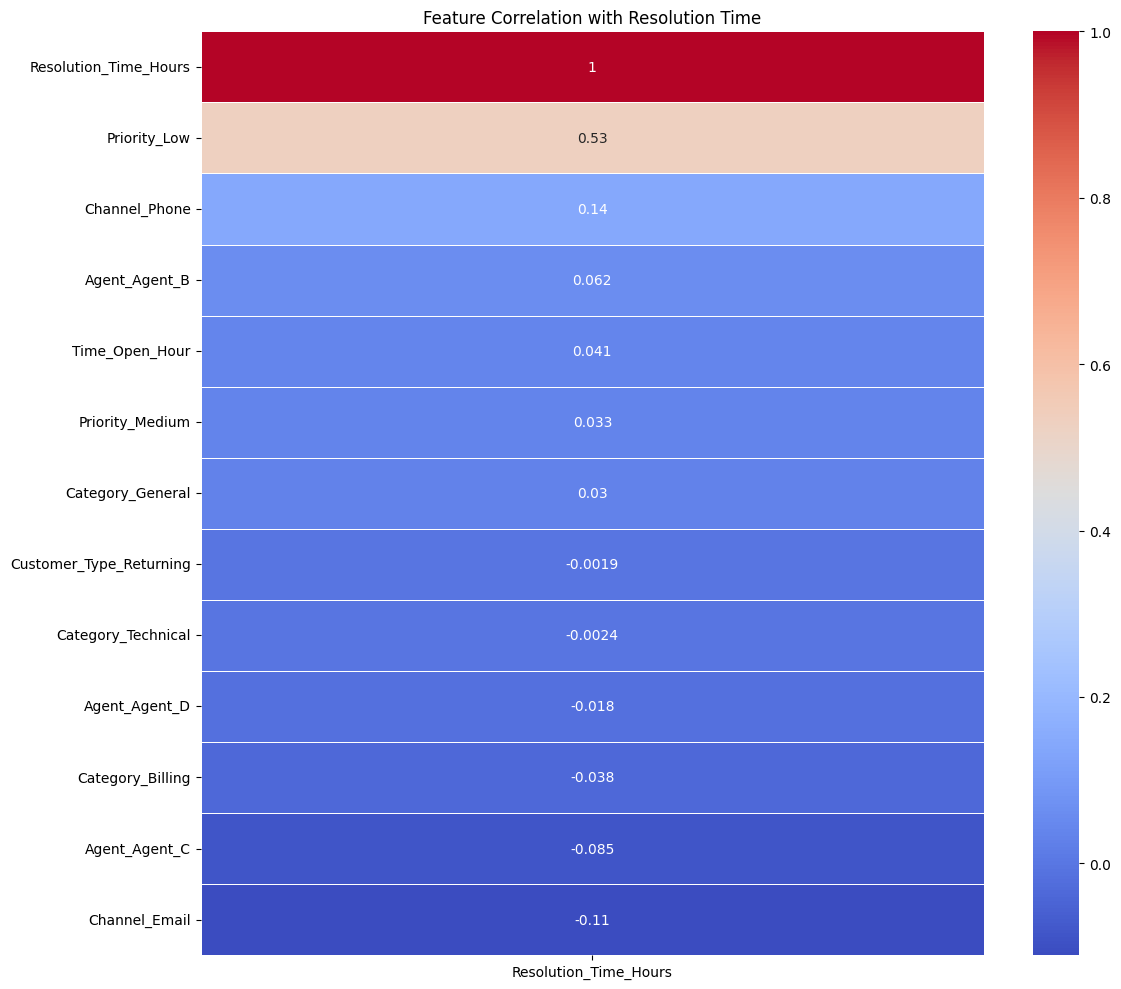

In [ ]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df.drop(columns=["Ticket_ID"]), drop_first=True)

# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap (focus on correlations with the target)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix[["Resolution_Time_Hours"]].sort_values(by="Resolution_Time_Hours", ascending=False),
    annot=True, cmap="coolwarm", linewidths=0.5
)
plt.title("Feature Correlation with Resolution Time")
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Save the entire pipeline (preprocessing + model)
joblib.dump(model, "customer_resolution_model.pkl")


['customer_resolution_model.pkl']

In [ ]:
# Load the model
loaded_model = joblib.load("customer_resolution_model.pkl")

# Use it to predict
predictions = loaded_model.predict(X_test)


In [ ]:

!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
# Load model
model = joblib.load("customer_resolution_model.pkl")

# Title
st.title("Customer Support Resolution Time Predictor")

# Input form
st.header("Ticket Information")
category = st.selectbox("Category", ["Billing", "Technical", "Account", "General"])
priority = st.selectbox("Priority", ["Low", "Medium", "High"])
channel = st.selectbox("Channel", ["Email", "Chat", "Phone"])
agent = st.selectbox("Agent", ["Agent_A", "Agent_B", "Agent_C", "Agent_D"])
customer_type = st.selectbox("Customer Type", ["New", "Returning"])
time_open = st.slider("Hour Ticket Was Opened", 0, 23, 9)

# Predict
if st.button("Predict Resolution Time"):
    input_df = pd.DataFrame([{
        "Category": category,
        "Priority": priority,
        "Channel": channel,
        "Agent": agent,
        "Customer_Type": customer_type,
        "Time_Open_Hour": time_open
    }])

    prediction = model.predict(input_df)[0]
    st.success(f"Estimated Resolution Time: {prediction:.1f} hours")

Writing app.py


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving customer_resolution_model.pkl to customer_resolution_model (1).pkl


In [ ]:
!ngrok authtoken 2vl8xQXPu1pGsk6VPCb17CbSAdP_3pNdjReMEbzMurzudF5SD
from pyngrok import ngrok
import os
import time
# The variable 'sleep' was assigned the result of time.sleep(5), which is None.
# This assignment is not necessary. We just need to call time.sleep() directly.
# sleep = time.sleep(5) # Remove this line

!pkill streamlit

# Create a tunnel to the default Streamlit port (8501)
public_url = ngrok.connect(addr=8501)
print("🌐 Streamlit app is live at:", public_url)

# Run the Streamlit app
!streamlit run app.py &
# Correctly call the time.sleep function to pause execution
time.sleep(5)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
🌐 Streamlit app is live at: NgrokTunnel: "https://15f7-34-19-36-254.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.36.254:8501

